### Import all the Dependencies

In [144]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [145]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

# Set the input image size for the leaf classifier
LEAF_IMAGE_SIZE = 64

# Define the leaf classifier model
leaf_classifier_model = models.Sequential([
    layers.Input(shape=(LEAF_IMAGE_SIZE, LEAF_IMAGE_SIZE, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the leaf classifier model
leaf_classifier_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Load and preprocess the leaf dataset for training the leaf classifier
leaf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "LeafDataset",
    seed=123,
    shuffle=True,
    image_size=(LEAF_IMAGE_SIZE, LEAF_IMAGE_SIZE),
    batch_size=32
)

# Train the leaf classifier model
leaf_classifier_model.fit(
    leaf_dataset,
    epochs=10
)

# Function to check if the input image is a leaf
def is_leaf_image(image_path):
    # Load and preprocess the input image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(LEAF_IMAGE_SIZE, LEAF_IMAGE_SIZE))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)
    
    # Predict the class probabilities using the leaf classifier model
    class_probabilities = leaf_classifier_model.predict(image_array)
    
    # Return True if the predicted probability of being a leaf is above a threshold (e.g., 0.5)
    return class_probabilities[0][0] > 0.5

# Prompt the user to enter the image file path
image_path = input("Enter the path to the image: ")

# Check if the image is a leaf
if is_leaf_image(image_path):
    # Load and preprocess the leaf image for the main model
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)
    image_array = resize_and_rescale(image_array)
    
    # Perform prediction using the main model
    predicted_class = model.predict(image_array)
    predicted_class = class_names[np.argmax(predicted_class)]
    
    print("Predicted leaf disease:", predicted_class)
else:
    print("Please insert a leaf image only.")


### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [146]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [147]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [148]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

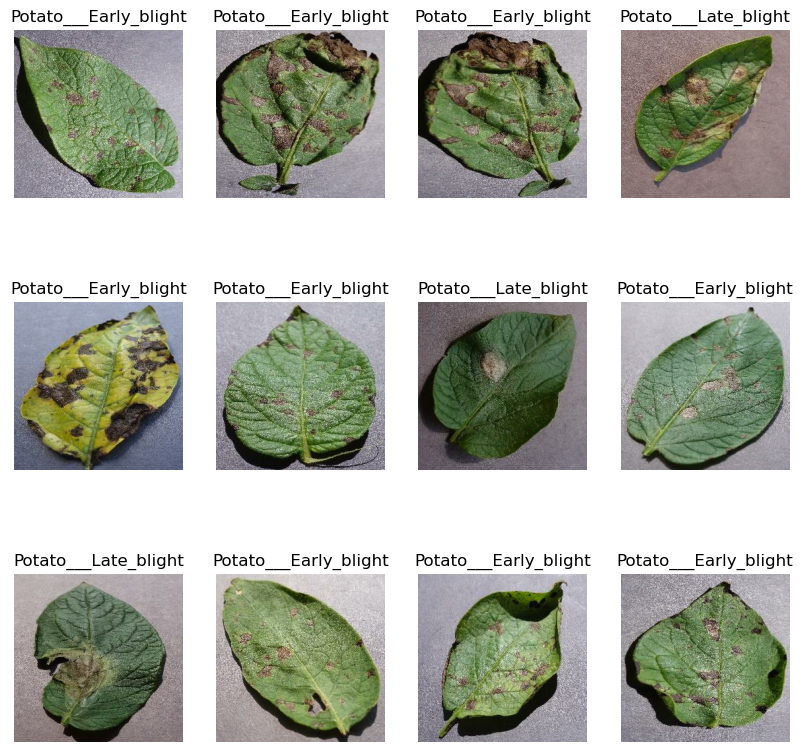

In [149]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [150]:
len(dataset)

68

In [151]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [152]:
train_ds = dataset.take(54)
len(train_ds)

54

In [153]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [154]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [155]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [156]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [157]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [158]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [159]:
len(train_ds)

54

In [160]:
len(val_ds)

6

In [161]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [162]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [163]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [164]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [165]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [166]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [167]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (32, 30, 30, 64)        

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [168]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [169]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
54/54 [==============================] - 98s 2s/step - loss: 0.9258 - accuracy: 0.4774 - val_loss: 0.8830 - val_accuracy: 0.5625
Epoch 2/20
54/54 [==============================] - 86s 2s/step - loss: 0.7776 - accuracy: 0.6140 - val_loss: 0.6148 - val_accuracy: 0.6927
Epoch 3/20
54/54 [==============================] - 91s 2s/step - loss: 0.4850 - accuracy: 0.7980 - val_loss: 0.4106 - val_accuracy: 0.8281
Epoch 4/20
54/54 [==============================] - 81s 1s/step - loss: 0.3166 - accuracy: 0.8663 - val_loss: 0.2953 - val_accuracy: 0.8958
Epoch 5/20
54/54 [==============================] - 94s 2s/step - loss: 0.3087 - accuracy: 0.8779 - val_loss: 0.4345 - val_accuracy: 0.8385
Epoch 6/20
54/54 [==============================] - 88s 2s/step - loss: 0.2725 - accuracy: 0.8987 - val_loss: 0.2630 - val_accuracy: 0.8750
Epoch 7/20
54/54 [==============================] - 94s 2s/step - loss: 0.1892 - accuracy: 0.9190 - val_loss: 0.2166 - val_accuracy: 0.9271
Epoch 8/20
54/54 [==

In [170]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 495ms/step - loss: 0.1253 - accuracy: 0.9531


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [171]:
scores

[0.12533731758594513, 0.953125]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [172]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [173]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [174]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [175]:
type(history.history['loss'])

list

In [176]:
len(history.history['loss'])

20

In [177]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.925829291343689,
 0.7776398658752441,
 0.4849556088447571,
 0.31660664081573486,
 0.3086594343185425]

In [178]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

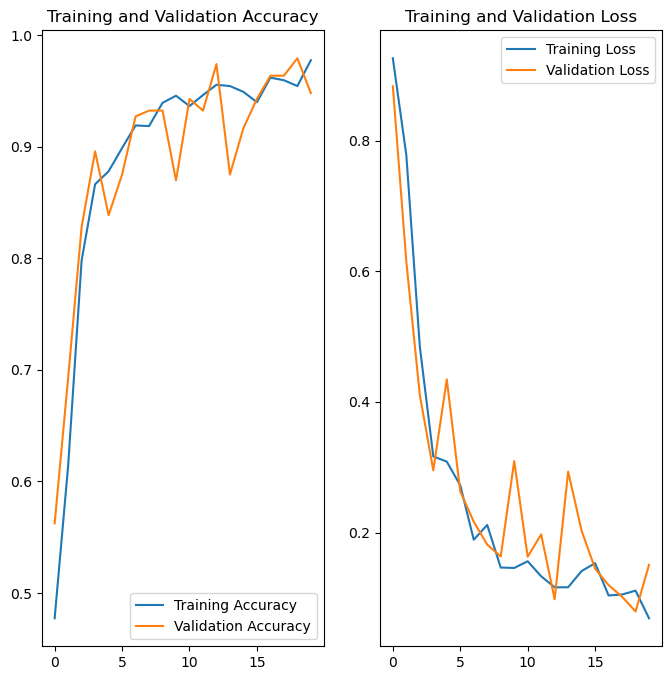

In [179]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


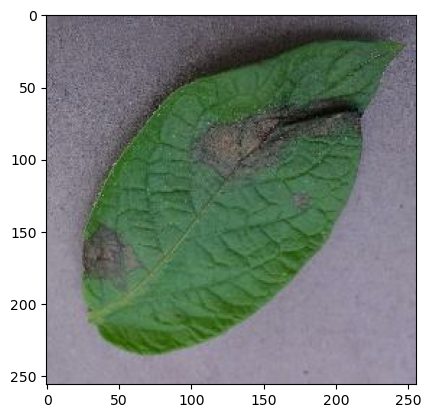

In [180]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

The image is a leaf.
First image to predict
Actual label: Potato___Late_blight
Predicted label: Potato___Late_blight


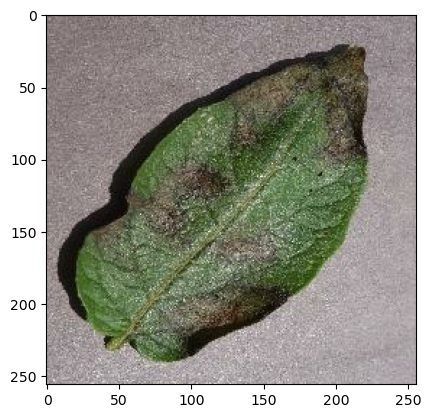

In [181]:
import cv2
import numpy as np

def is_leaf(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper thresholds for green color (adjusted values)
    lower_green = np.array([0, 50, 50])  # Lower threshold for green color in HSV
    upper_green = np.array([100, 255, 255])  # Upper threshold for green color in HSV

    # Threshold the image to extract green regions
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Count the number of non-zero pixels in the mask
    num_green_pixels = np.count_nonzero(mask)

    # Calculate the percentage of green pixels relative to the total image area
    green_pixel_ratio = num_green_pixels / (image.shape[0] * image.shape[1])

    # If green pixel ratio is above a threshold, consider it as a leaf
    if green_pixel_ratio > 0.1:  # Adjust the threshold as needed
        return True
    else:
        return False
    
import numpy as np
import matplotlib.pyplot as plt

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()


    # Resize the image to (256, 256)
    resized_image = cv2.resize(first_image, (256, 256))



    
    # Check if the image is a leaf
    if is_leaf(resized_image):
        print("The image is a leaf.")
            
        print("First image to predict")
        plt.imshow(first_image)
        print("Actual label:", class_names[first_label])

        batch_prediction = model.predict(images_batch)
        print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
        
    else:
        print("The image is not a leaf.")
        print("Enter the image of a leaf")
        
        


### Write a function for inference

In [182]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

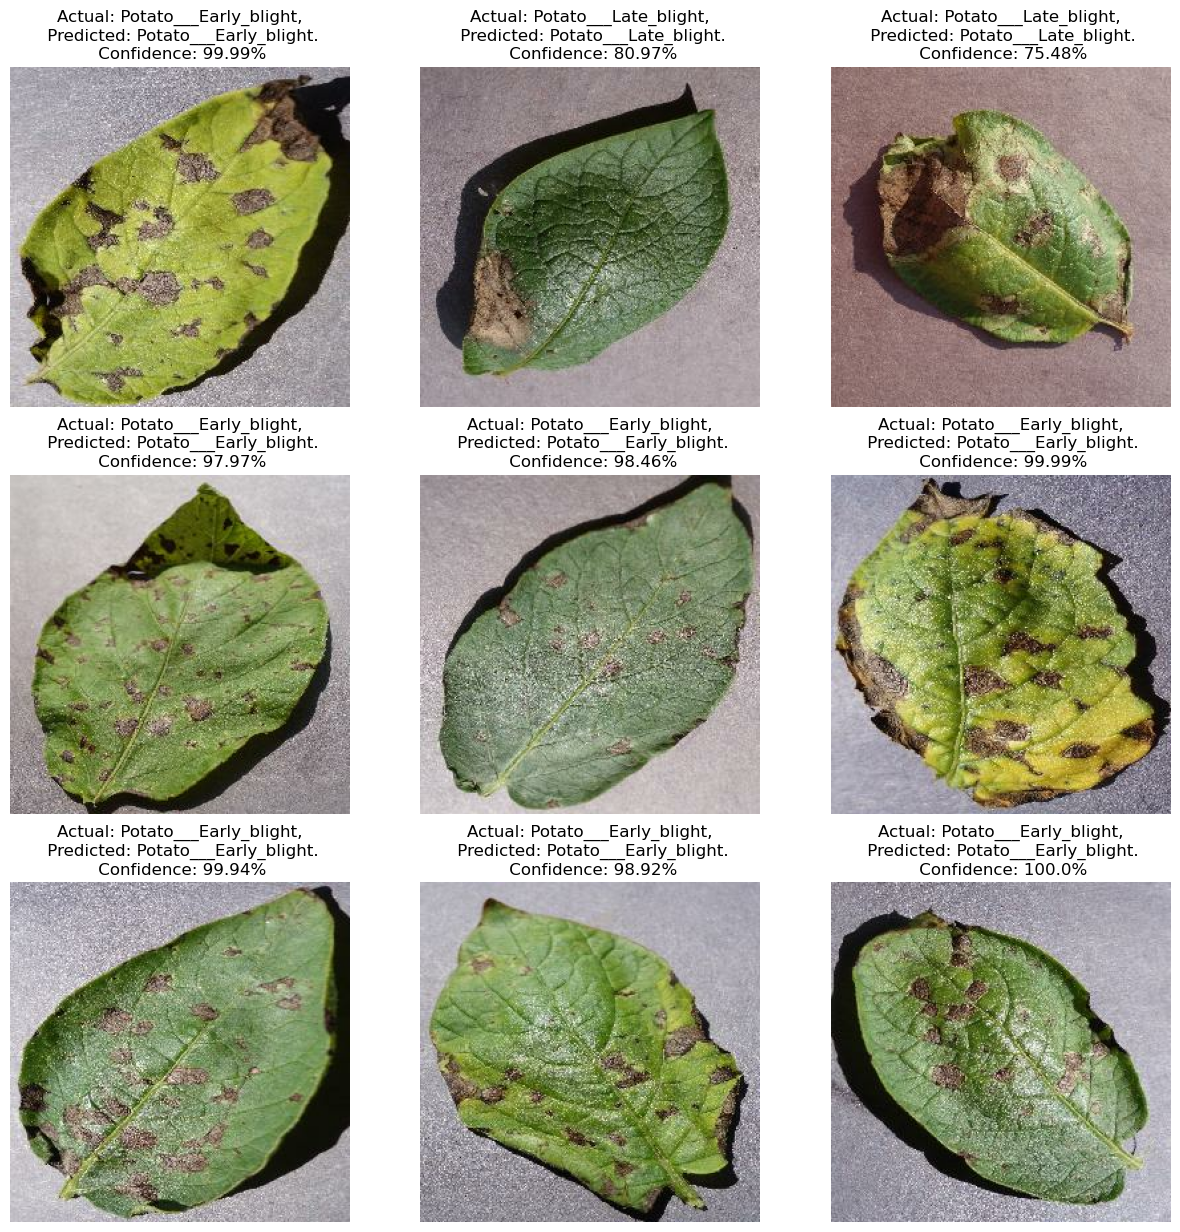

In [183]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import tensorflow_model_optimization as tfmot

# Define the path to save the quantized model
quantized_model_path = 'quantized_model'

# Convert the model to a quantization-aware model
quantize_model = tfmot.quantization.keras.quantize_model
quantized_model = quantize_model(model)

# Compile the quantized model
quantized_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the quantized model
quantized_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

# Save the quantized model
quantized_model.save(quantized_model_path)

### Saving the Model
We append the model to the list of models as a new version

In [184]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [185]:
model.save("../potatoes.h5")

In [ ]:
## Tensor Flow Lite

In [ ]:
# Load the saved model
saved_model_dir = 'path_to_saved_model_directory'
model = tf.keras.models.load_model(saved_model_dir)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
tflite_model_path = 'path_to_save_tflite_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
    
    
converter.optimizations = [tf.lite.Optimize.DEFAULT]